In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
# Specify path to cleaned weather csv
path = Path()
cleaned_weather_csv_path = path/'..'/'data'/'processed'/'weather_data'/'weather_data.csv'
# Read in as dataframe from csv
df_weather = pd.read_csv(cleaned_weather_csv_path)

In [3]:
# Specify path to target variable csv
target_var_csv_path = path/'..'/'data'/'processed'/'influenza_data'/'y_var.csv'
# Read in as dataframe from csv
df_target = pd.read_csv(target_var_csv_path)

In [4]:
# Merge data and handle missing values
df_weather_target = pd.merge(left=df_weather, right=df_target, how='left', left_on=['county', 'datetime'], right_on=['County', 'Week Ending Date']).drop(labels=['County', 'Week Ending Date'], axis=1)
df_weather_target['Count'] = df_weather_target['Count'].fillna(0)
df_weather_target['Count'] = df_weather_target['Count'].astype('int')

In [5]:
# Convert datetime column to datetime type
df_weather_target['datetime'] = pd.to_datetime(df_weather_target['datetime'])

In [6]:
df_weather_target.head()

,Unnamed: 0,county,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,moonphase,conditions,Count
0,0,ALBANY,2020-01-11,41.142857,26.614286,34.714286,37.685714,18.328571,28.842857,21.814286,...,1019.642857,68.114286,9.471429,56.228571,4.900000,2.857143,NaN,0.452857,"Snow, Rain, Partially cloudy",0
1,1,ALLEGANY,2020-01-11,36.700000,24.114286,31.128571,30.671429,14.471429,23.042857,24.214286,...,1019.714286,64.100000,8.028571,36.657143,3.128571,1.857143,NaN,0.452857,Partially cloudy,0
2,2,BRONX,2020-01-11,46.000000,34.300000,40.357143,42.485714,26.328571,34.514286,25.842857,...,1021.385714,59.428571,9.700000,66.142857,5.714286,3.428571,NaN,0.452857,Partially cloudy,0
3,3,BROOME,2020-01-11,36.142857,23.757143,30.642857,31.271429,14.442857,23.300000,23.300000,...,1019.542857,66.271429,8.628571,42.214286,3.657143,2.571429,NaN,0.452857,"Snow, Rain, Partially cloudy",0
4,4,CATTARAUGUS,2020-01-11,39.014286,26.828571,33.285714,32.300000,17.785714,25.442857,25.400000,...,1019.385714,63.828571,8.185714,25.542857,2.157143,1.285714,NaN,0.452857,"Snow, Rain, Partially cloudy",0


In [8]:
# Remove redundant index column
df_weather_target = df_weather_target.drop(columns=['Unnamed: 0'])

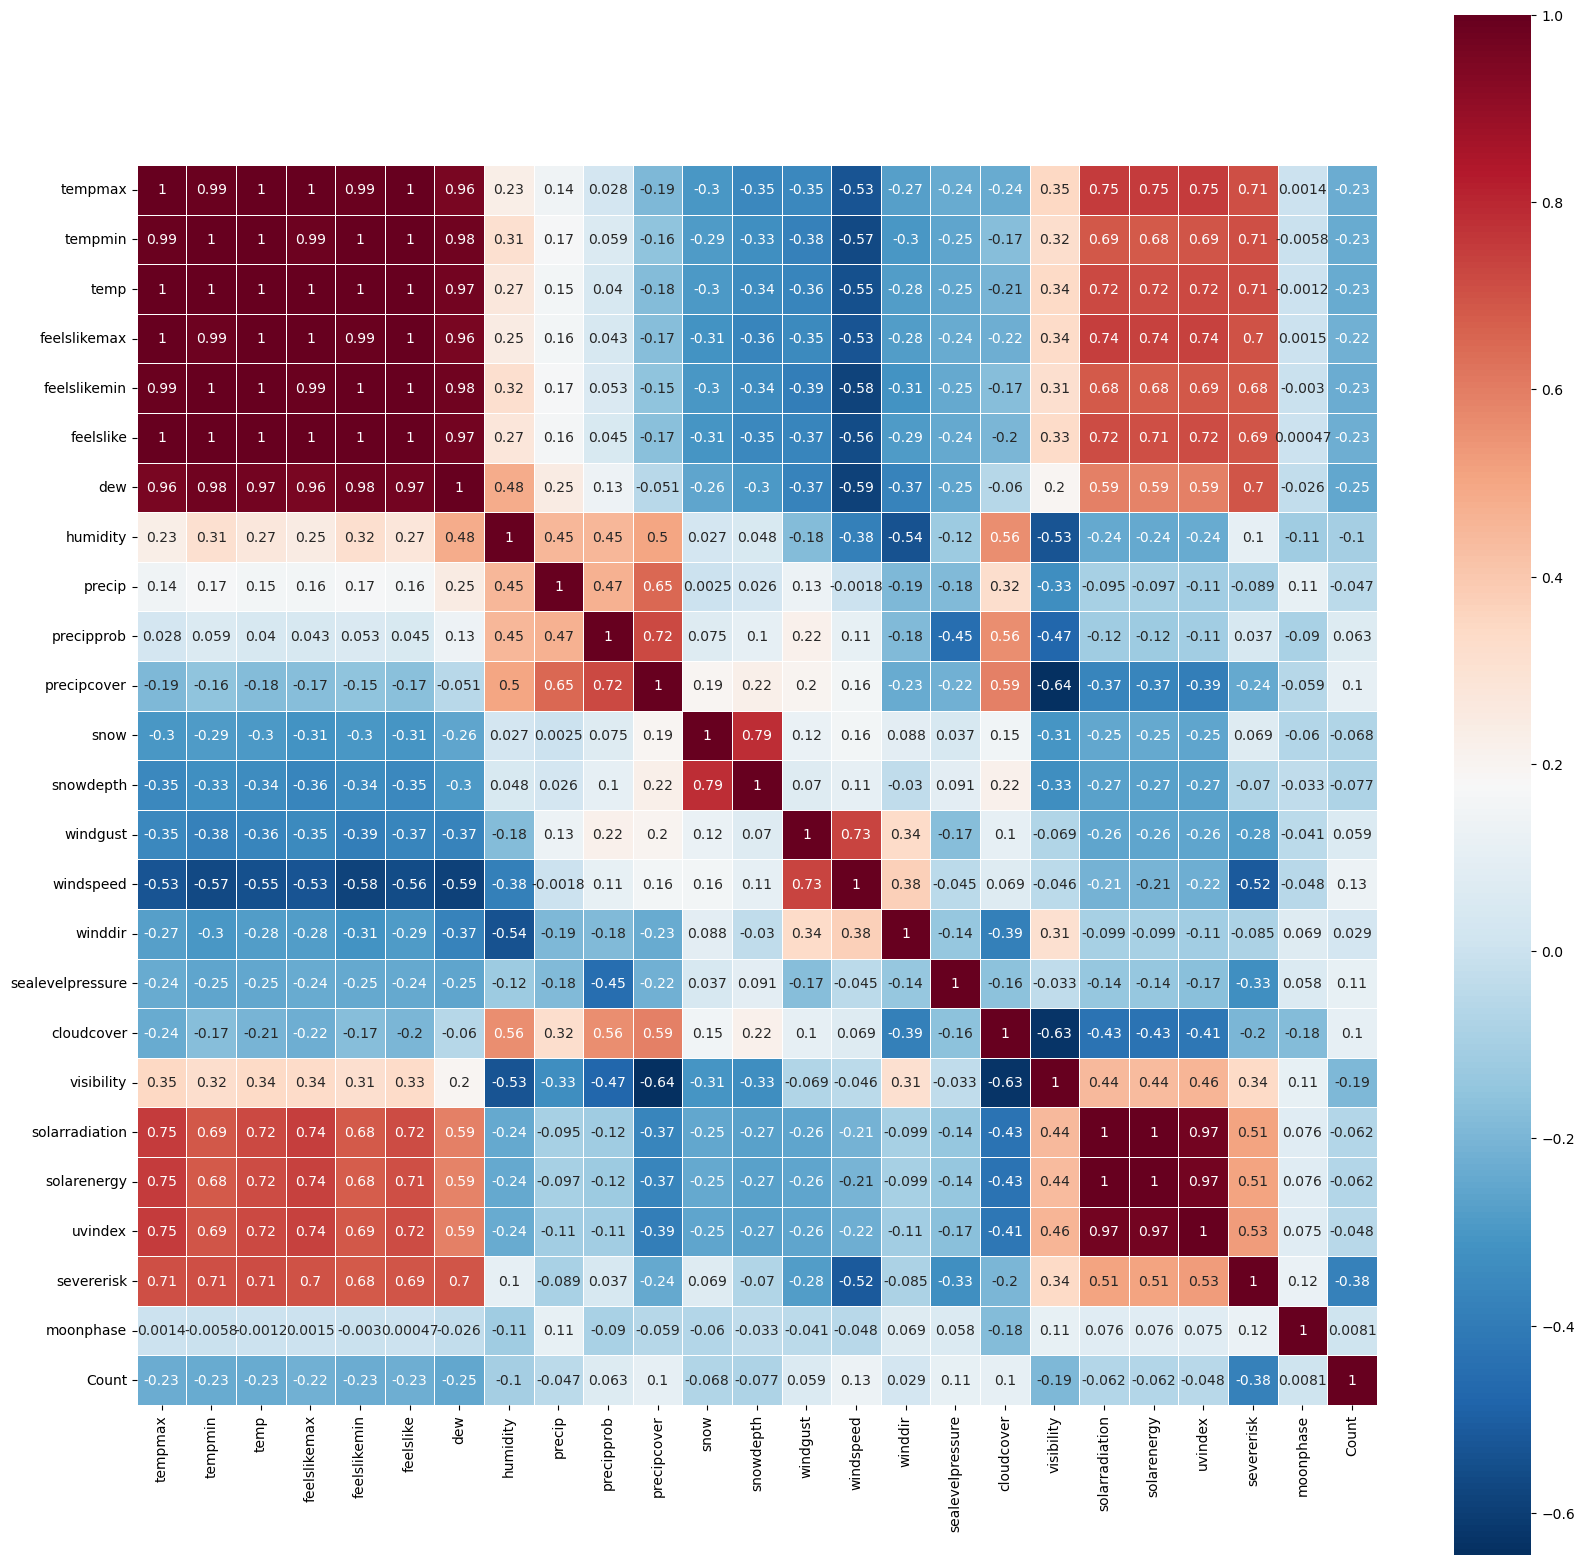

In [9]:
# Plot Pearson Correlation matrix heatmap to visualize correlation between weather features and case count
plt.figure(figsize=(20,20))
corr_matrix = df_weather_target[df_weather_target['county'] == 'BRONX'].corr(method='pearson')
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', linewidth=0.5, square=True)
plt.show()

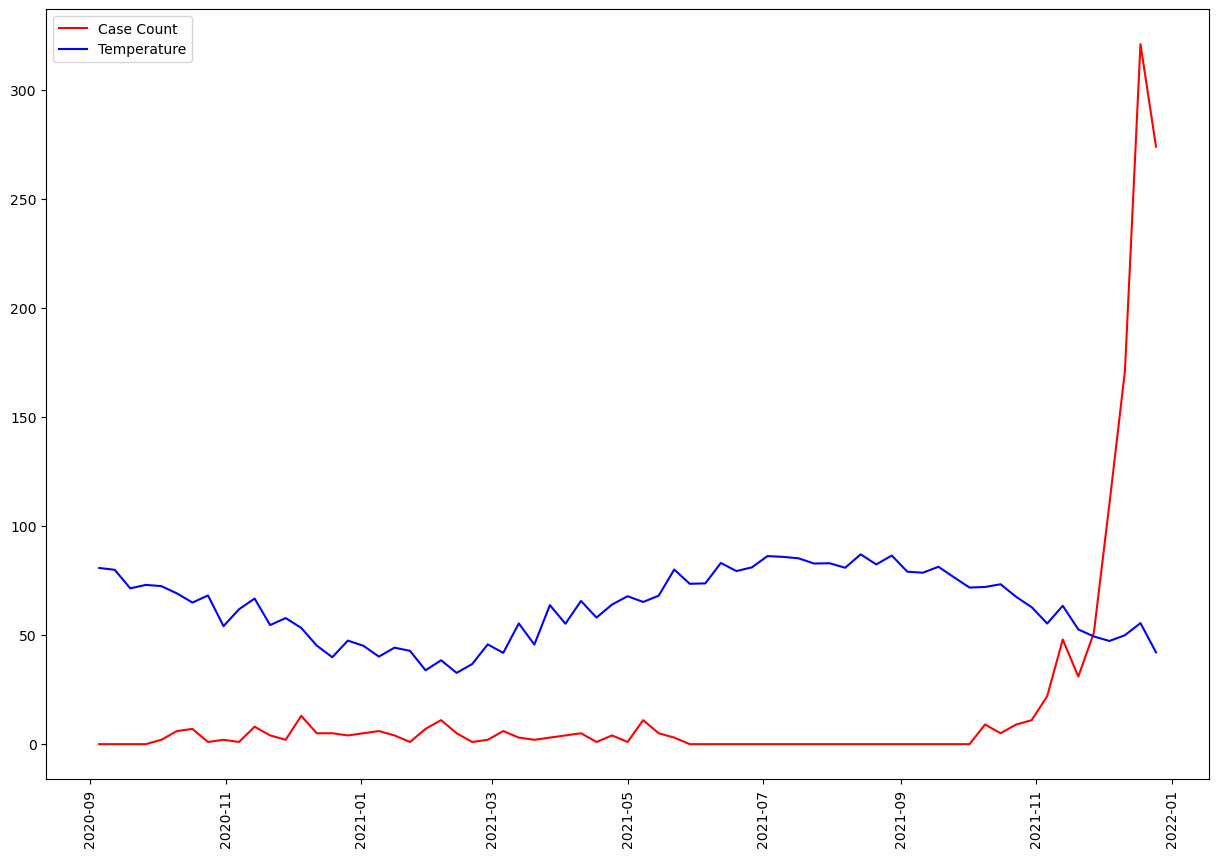

In [10]:
# Plot line chart to visualize trend and relationship between temperature and case count
df_weather_target_bronx = df_weather_target[(df_weather_target['county'] == 'BRONX') & ((df_weather_target['datetime'] >= '2020-09-01') & (df_weather_target['datetime'] <= '2021-12-31'))]
plt.figure(figsize=(15,10))
plt.plot(df_weather_target_bronx['datetime'], df_weather_target_bronx['Count'], color='red', label='Case Count')
plt.plot(df_weather_target_bronx['datetime'], df_weather_target_bronx['tempmax'], color='blue', label='Temperature')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [11]:
# Identify NA values in features
X = df_weather_target.drop(labels=['Count', 'county', 'conditions', 'datetime', 'preciptype'], axis=1)
X.isna().any()

tempmax             False
tempmin             False
temp                False
feelslikemax        False
feelslikemin        False
feelslike           False
dew                 False
humidity            False
precip              False
precipprob          False
precipcover         False
snow                False
snowdepth           False
windgust             True
windspeed           False
winddir             False
sealevelpressure     True
cloudcover          False
visibility          False
solarradiation      False
solarenergy         False
uvindex             False
severerisk           True
moonphase           False
dtype: bool

,Feature,F-Score
7,humidity,219.647862
14,windspeed,149.912778
11,snow,133.321979
6,dew,121.601936
13,windgust,80.369216
0,tempmax,77.192344
3,feelslikemax,73.760536
5,feelslike,63.110393
2,temp,61.450168
22,severerisk,59.429183


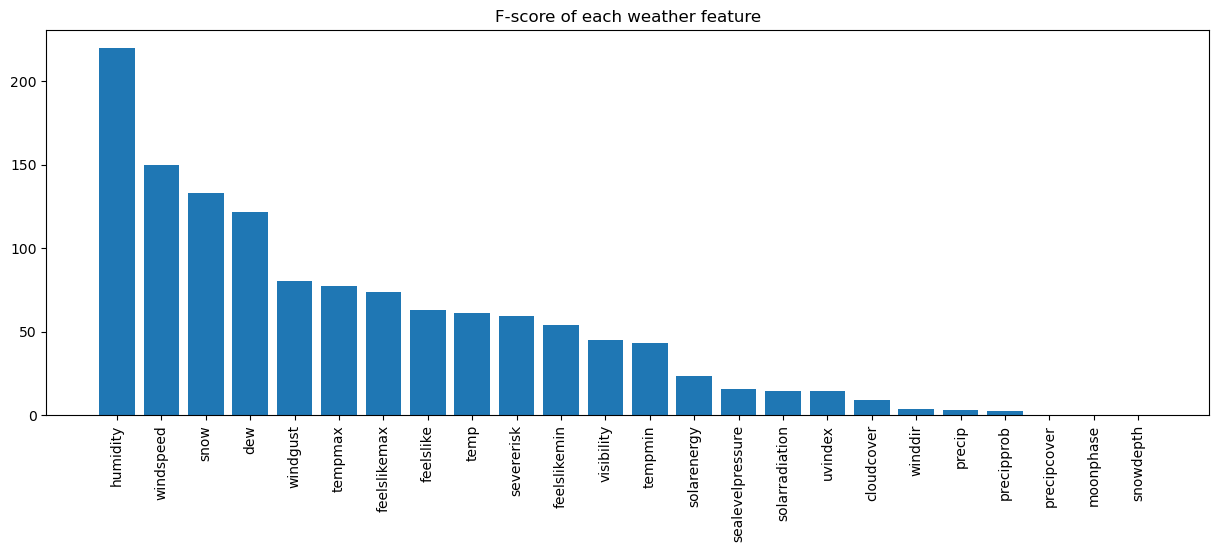

In [12]:
# Fill NA values because SelectKBest cannot tolerate NA
X = df_weather_target.drop(labels=['Count', 'county', 'conditions', 'datetime', 'preciptype'], axis=1)
X = X.fillna(value={'windgust': X['windgust'].mean(), 'sealevelpressure': X['sealevelpressure'].mean(), 'severerisk': X['severerisk'].mean()})
y = df_weather_target['Count']
# Perform univariate feature selection analysis
ftest = SelectKBest(score_func=f_regression, k='all')
ftest.fit(X, y)
f_scores = pd.DataFrame(ftest.scores_)
dfcolumns = pd.DataFrame(X.columns)
f_scores = pd.concat([dfcolumns, f_scores], axis=1)
f_scores.columns = ['Feature', 'F-Score']  
f_scores = f_scores.sort_values(by='F-Score', ascending=False)
display(f_scores)
# Plot scores to visualize most important weather features in relation to case count determined by SelectKBest F-regression
plt.figure(figsize=(15,5))
plt.bar(x=f_scores['Feature'], height=f_scores['F-Score'])
plt.xticks(rotation=90)
plt.title('F-score of each weather feature')
plt.show()

In [13]:
# Show the 1/2 most important weather features identified by SelectKBest F-regression
f_scores.iloc[:int(f_scores.shape[0]/2)]['Feature']

7         humidity
14       windspeed
11            snow
6              dew
13        windgust
0          tempmax
3     feelslikemax
5        feelslike
2             temp
22      severerisk
4     feelslikemin
18      visibility
Name: Feature, dtype: object